In [66]:
import nibabel as nib
import numpy as np
import os
import matplotlib.pyplot as plt
from pytorch_msssim import ms_ssim
import torch
from torchvision.transforms.functional import to_tensor
from tqdm import tqdm
from scipy.stats import norm
import statistics
import matplotlib

In [69]:
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'text.usetex': True,
    'pgf.rcfonts': False,
})

In [7]:
### GENERATE MEAN IMAGE ###

folder_path = '/home/barisbaydargil/OASIS_PREPROCESSED/NC'

file_list = os.listdir(folder_path)
nifti_list = [file for file in file_list if file.endswith('.nii.gz')]

nifti_path = os.path.join(folder_path, nifti_list[0])
affine = nib.load(nifti_path).affine
header = nib.load(nifti_path).header

batch_size = 20

mean_data = None

for i in range(0, len(nifti_list), batch_size):
    data_list = []
    for j in range(i, min(i+batch_size, len(nifti_list))):
        nifti_path = os.path.join(folder_path, nifti_list[j])
        nifti_data = nib.load(nifti_path).get_fdata()
        data_list.append(nifti_data)
    data_array = np.array(data_list)

    batch_mean = np.mean(data_array, axis=0)

    if mean_data is None:
        mean_data = batch_mean
    else:
        mean_data += batch_mean

mean_data /= (len(nifti_list) // batch_size + 1)

mean_nifti = nib.Nifti1Image(mean_data, affine, header)

nib.save(mean_nifti, '/home/barisbaydargil/3D_classification/realoasis_nc_mean.nii.gz')

In [71]:
### CREATE SSIM BETWEEN THE MEAN IMAGE AND THE DATASET ###
folder_path = '/home/barisbaydargil/adni_fake_sota/SOTA_ADNI_AD_fakes'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the main nifti image
main_nifti_path = '/home/barisbaydargil/3D_classification/adni_ad_avgimg.nii.gz'
main_nifti_data = nib.load(main_nifti_path).get_fdata()
img1 = to_tensor(main_nifti_data).to(device)
ms_ssim_list = []

for filename in tqdm(os.listdir(folder_path)):
    if filename.endswith('.nii.gz'):
        # Load the current nifti image
        nifti_path = os.path.join(folder_path, filename)
        nifti_data = nib.load(nifti_path).get_fdata()
        img2 = to_tensor(nifti_data).to(device)
        ms_ssim_value = ms_ssim(img1.unsqueeze(0), img2.unsqueeze(0), data_range=1.0, win_size=7, size_average=True)
        ms_ssim_list.append(ms_ssim_value)


100%|███████████████████████████████████████████████████████████| 512/512 [02:11<00:00,  3.88it/s]


0.18594898232154417 0.008386545052439786 0.1942411252211401 0.14991284083437553


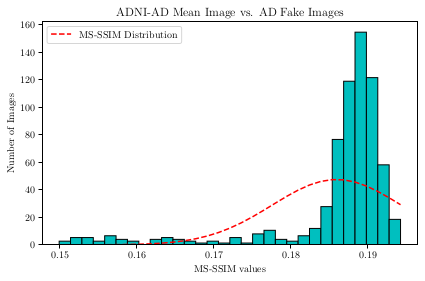

In [72]:
my_list_values = [x.tolist() if isinstance(x, torch.Tensor) else x for x in ms_ssim_list]

mean = statistics.mean(my_list_values)
std = statistics.stdev(my_list_values)

print(np.mean(my_list_values), np.std(my_list_values), max(my_list_values), min(my_list_values))


fig, ax = plt.subplots()

n, bins, patches = ax.hist(my_list_values, 30, density=1, color='c', edgecolor='k')

y = ((1 / (np.sqrt(2 * np.pi) * std)) *
     np.exp(-0.5 * (1 / std * (bins - mean))**2))
ax.plot(bins, y, '--', color='r')


ax.legend(['MS-SSIM Distribution'])

ax.set_xlabel('MS-SSIM values')
ax.set_ylabel('Number of Images')
ax.set_title('ADNI-AD Mean Image vs. AD Fake Images')

fig.tight_layout()
plt.show()

plt.savefig('/home/barisbaydargil/3D_classification/ssim_plots/ms_ssim_realadni_ad_vs_fakeadni_ad.pgf')

# save as png format
plt.savefig('/home/barisbaydargil/3D_classification/ssim_plots/ms_ssim_realadni_vs_fakeadni.png', dpi=400)

In [73]:
### CREATE SSIM BTW THE MEAN IMAGE AND THE DATASET ###
folder_path = '/home/barisbaydargil/3D_classification/ADNI_preprocessed/AD'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

main_nifti_path = '/home/barisbaydargil/3D_classification/adni_ad_avgimg.nii.gz'
main_nifti_data = nib.load(main_nifti_path).get_fdata()
img1 = to_tensor(main_nifti_data).to(device)
ms_ssim_list = []

for filename in tqdm(os.listdir(folder_path)):
    if filename.endswith('.nii.gz'):
        nifti_path = os.path.join(folder_path, filename)
        nifti_data = nib.load(nifti_path).get_fdata()
        img2 = to_tensor(nifti_data).to(device)
        ms_ssim_value = ms_ssim(img1.unsqueeze(0), img2.unsqueeze(0), data_range=1.0, win_size=7, size_average=True)

        ms_ssim_list.append(ms_ssim_value)


100%|███████████████████████████████████████████████████████████| 593/593 [02:21<00:00,  4.18it/s]


593
0.647948701395255 0.08654919370144801 0.7748902241155318 0.32567005946273336


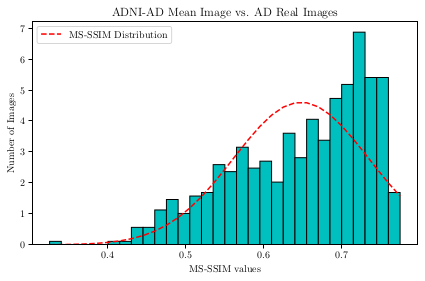

In [74]:
my_list_values = [x.tolist() if isinstance(x, torch.Tensor) else x for x in ms_ssim_list]
print(len(my_list_values))
mean = statistics.mean(my_list_values)
std = statistics.stdev(my_list_values)

print(np.mean(my_list_values), np.std(my_list_values), max(my_list_values), min(my_list_values))


fig, ax = plt.subplots()

n, bins, patches = ax.hist(my_list_values, 30, density=1, color='c', edgecolor='k')

y = ((1 / (np.sqrt(2 * np.pi) * std)) *
     np.exp(-0.5 * (1 / std * (bins - mean))**2))
ax.plot(bins, y, '--', color='r')

ax.legend(['MS-SSIM Distribution'])

ax.set_xlabel('MS-SSIM values')
ax.set_ylabel('Number of Images')
ax.set_title('ADNI-AD Mean Image vs. AD Real Images')

fig.tight_layout()
plt.show()

plt.savefig('/home/barisbaydargil/3D_classification/ssim_plots/ms_ssim_realadni_vs_realadni.pgf')

# save as png format
plt.savefig('/home/barisbaydargil/3D_classification/ssim_plots/ms_ssim_realadni_ad_vs_realadni_ad.png', dpi=600)

In [75]:
### CREATE SSIM BETWEEN THE MEAN IMAGE AND THE DATASET ###
folder_path = '/home/barisbaydargil/3D_classification/ADNI_preprocessed/NC'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the main nifti image
main_nifti_path = '/home/barisbaydargil/3D_classification/adni_nc_avgimg.nii.gz'
main_nifti_data = nib.load(main_nifti_path).get_fdata()
img1 = to_tensor(main_nifti_data).to(device)
ms_ssim_list = []

for filename in tqdm(os.listdir(folder_path)):
    if filename.endswith('.nii.gz'):
        nifti_path = os.path.join(folder_path, filename)
        nifti_data = nib.load(nifti_path).get_fdata()
        img2 = to_tensor(nifti_data).to(device)
        ms_ssim_value = ms_ssim(img1.unsqueeze(0), img2.unsqueeze(0), data_range=1.0, win_size=7, size_average=True)
        ms_ssim_list.append(ms_ssim_value)


100%|███████████████████████████████████████████████████████████| 512/512 [02:05<00:00,  4.09it/s]


512
0.6594992937987911 0.0683372722150387 0.7805330891296273 0.37737289286453946


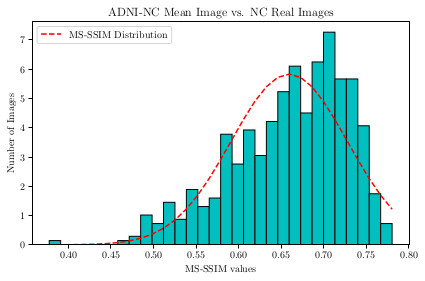

In [76]:
my_list_values = [x.tolist() if isinstance(x, torch.Tensor) else x for x in ms_ssim_list]
print(len(my_list_values))
mean = statistics.mean(my_list_values)
std = statistics.stdev(my_list_values)

print(np.mean(my_list_values), np.std(my_list_values), max(my_list_values), min(my_list_values))


fig, ax = plt.subplots()

n, bins, patches = ax.hist(my_list_values, 30, density=1, color='c', edgecolor='k')

y = ((1 / (np.sqrt(2 * np.pi) * std)) *
     np.exp(-0.5 * (1 / std * (bins - mean))**2))
ax.plot(bins, y, '--', color='r')

ax.legend(['MS-SSIM Distribution'])

ax.set_xlabel('MS-SSIM values')
ax.set_ylabel('Number of Images')
ax.set_title('ADNI-NC Mean Image vs. NC Real Images')

fig.tight_layout()
plt.show()

plt.savefig('/home/barisbaydargil/3D_classification/ssim_plots/ms_ssim_realadni_nc_vs_realadni_nc.pgf')

# save as png format
plt.savefig('/home/barisbaydargil/3D_classification/ssim_plots/ms_ssim_realadni_nc_vs_realadni_nc.png', dpi=400)

In [77]:
### CREATE SSIM BETWEEN THE MEAN IMAGE AND THE DATASET ###
folder_path = '/home/barisbaydargil/adni_fake_sota/SOTA_NC_fakes'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the main nifti image
main_nifti_path = '/home/barisbaydargil/3D_classification/adni_nc_avgimg.nii.gz'
main_nifti_data = nib.load(main_nifti_path).get_fdata()
img1 = to_tensor(main_nifti_data).to(device)
ms_ssim_list = []

for filename in tqdm(os.listdir(folder_path)):
    if filename.endswith('.nii.gz'):
        nifti_path = os.path.join(folder_path, filename)
        nifti_data = nib.load(nifti_path).get_fdata()
        img2 = to_tensor(nifti_data).to(device)
        ms_ssim_value = ms_ssim(img1.unsqueeze(0), img2.unsqueeze(0), data_range=1.0, win_size=7, size_average=True)
        ms_ssim_list.append(ms_ssim_value)

100%|███████████████████████████████████████████████████████████| 512/512 [02:00<00:00,  4.27it/s]


512
0.16155038136199415 0.004072830295769413 0.17065825575217874 0.14789715320897687


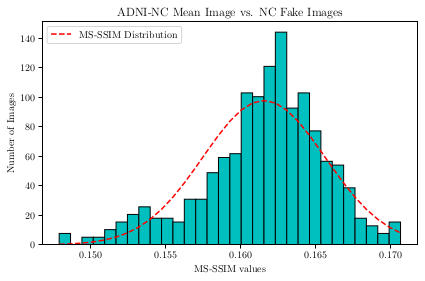

In [78]:
my_list_values = [x.tolist() if isinstance(x, torch.Tensor) else x for x in ms_ssim_list]
print(len(my_list_values))
mean = statistics.mean(my_list_values)
std = statistics.stdev(my_list_values)

print(np.mean(my_list_values), np.std(my_list_values), max(my_list_values), min(my_list_values))


fig, ax = plt.subplots()

n, bins, patches = ax.hist(my_list_values, 30, density=1, color='c', edgecolor='k')

y = ((1 / (np.sqrt(2 * np.pi) * std)) *
     np.exp(-0.5 * (1 / std * (bins - mean))**2))
ax.plot(bins, y, '--', color='r')

ax.legend(['MS-SSIM Distribution'])

ax.set_xlabel('MS-SSIM values')
ax.set_ylabel('Number of Images')
ax.set_title('ADNI-NC Mean Image vs. NC Fake Images')

fig.tight_layout()
plt.show()

plt.savefig('/home/barisbaydargil/3D_classification/ssim_plots/ms_ssim_realadni_nc_vs_fakeadni_nc.pgf')

# save as png format
plt.savefig('/home/barisbaydargil/3D_classification/ssim_plots/ms_ssim_realadni_nc_vs_fakeadni_nc.png', dpi=400)

In [79]:
### CREATE SSIM BETWEEN THE MEAN IMAGE AND THE DATASET ###
folder_path = '/home/barisbaydargil/adni_fake_sota/SOTA_ADNI_AD_fakes'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the main nifti image
main_nifti_path = '/home/barisbaydargil/3D_classification/adni_nc_avgimg.nii.gz'
main_nifti_data = nib.load(main_nifti_path).get_fdata()
img1 = to_tensor(main_nifti_data).to(device)
ms_ssim_list = []

# Loop over the nifti files in the folder
for filename in tqdm(os.listdir(folder_path)):
    if filename.endswith('.nii.gz'):
        # Load the current nifti image
        nifti_path = os.path.join(folder_path, filename)
        nifti_data = nib.load(nifti_path).get_fdata()
        img2 = to_tensor(nifti_data).to(device)
        ms_ssim_value = ms_ssim(img1.unsqueeze(0), img2.unsqueeze(0), data_range=1.0, win_size=7, size_average=True)
        ms_ssim_list.append(ms_ssim_value)


100%|███████████████████████████████████████████████████████████| 512/512 [02:13<00:00,  3.84it/s]


512
0.15296446293957194 0.004664543806975132 0.16875761114419127 0.11160789967401419


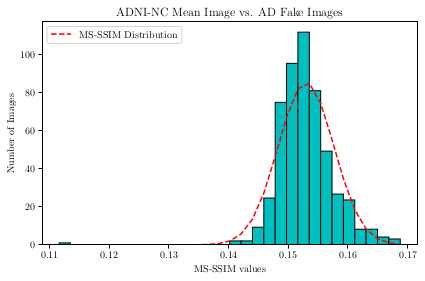

In [80]:
my_list_values = [x.tolist() if isinstance(x, torch.Tensor) else x for x in ms_ssim_list]
print(len(my_list_values))
mean = statistics.mean(my_list_values)
std = statistics.stdev(my_list_values)

print(np.mean(my_list_values), np.std(my_list_values), max(my_list_values), min(my_list_values))


fig, ax = plt.subplots()

n, bins, patches = ax.hist(my_list_values, 30, density=1, color='c', edgecolor='k')

y = ((1 / (np.sqrt(2 * np.pi) * std)) *
     np.exp(-0.5 * (1 / std * (bins - mean))**2))
ax.plot(bins, y, '--', color='r')

ax.legend(['MS-SSIM Distribution'])

ax.set_xlabel('MS-SSIM values')
ax.set_ylabel('Number of Images')
ax.set_title('ADNI-NC Mean Image vs. AD Fake Images')

fig.tight_layout()
plt.show()

plt.savefig('/home/barisbaydargil/3D_classification/ssim_plots/ms_ssim_realadni_nc_vs_fakeadni_ad.pgf')

# save as png format
plt.savefig('/home/barisbaydargil/3D_classification/ssim_plots/ms_ssim_realadni_nc_vs_fakeadni_ad.png', dpi=400)

In [81]:
### CREATE SSIM BETWEEN THE MEAN IMAGE AND THE DATASET ###
folder_path = '/home/barisbaydargil/adni_fake_sota/SOTA_NC_fakes'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

main_nifti_path = '/home/barisbaydargil/3D_classification/adni_ad_avgimg.nii.gz'
main_nifti_data = nib.load(main_nifti_path).get_fdata()
img1 = to_tensor(main_nifti_data).to(device)
ms_ssim_list = []

for filename in tqdm(os.listdir(folder_path)):
    if filename.endswith('.nii.gz'):
        # Load the current nifti image
        nifti_path = os.path.join(folder_path, filename)
        nifti_data = nib.load(nifti_path).get_fdata()
        img2 = to_tensor(nifti_data).to(device)
        ms_ssim_value = ms_ssim(img1.unsqueeze(0), img2.unsqueeze(0), data_range=1.0, win_size=7, size_average=True)
        ms_ssim_list.append(ms_ssim_value)


100%|███████████████████████████████████████████████████████████| 512/512 [01:59<00:00,  4.28it/s]


512
0.17394766222289826 0.008527631624724832 0.19556191852794905 0.15185766192172034


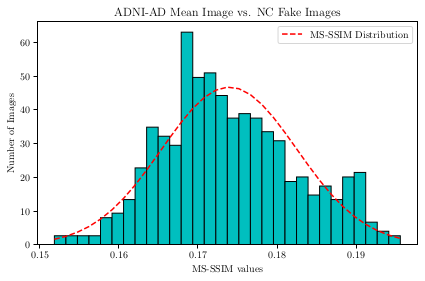

In [82]:
my_list_values = [x.tolist() if isinstance(x, torch.Tensor) else x for x in ms_ssim_list]
print(len(my_list_values))
mean = statistics.mean(my_list_values)
std = statistics.stdev(my_list_values)

print(np.mean(my_list_values), np.std(my_list_values), max(my_list_values), min(my_list_values))


fig, ax = plt.subplots()

n, bins, patches = ax.hist(my_list_values, 30, density=1, color='c', edgecolor='k')

y = ((1 / (np.sqrt(2 * np.pi) * std)) *
     np.exp(-0.5 * (1 / std * (bins - mean))**2))
ax.plot(bins, y, '--', color='r')

ax.legend(['MS-SSIM Distribution'])

ax.set_xlabel('MS-SSIM values')
ax.set_ylabel('Number of Images')
ax.set_title('ADNI-AD Mean Image vs. NC Fake Images')
fig.patch.set_facecolor('white')

fig.tight_layout()
plt.show()

plt.savefig('/home/barisbaydargil/3D_classification/ssim_plots/ms_ssim_realadni_ad_vs_fakeadni_nc.pgf')

# save as png format
plt.savefig('/home/barisbaydargil/3D_classification/ssim_plots/ms_ssim_realadni_ad_vs_fakeadni_nc.png', dpi=400)